# Chinese Restaurant Clustering

***

The goal of this notebook is to cluster neighborhoods of New York City to find the best neighborhoods to open a new Chinese restaurant. 

In the first section, we will extract the neighborhood data and population data from external sites. 

In the second section, we will use Foursquare to find the Chinese restaurants in a neighborhood. Foursquare will also be used to find venue data for each restaurant, like rating and like-count.

The final section is where the clustering occurs. Kmeans clustering will be performed four times with four different list of features. Each clustering will be displayed using Folium. The best clustering will be the clustering with the highest average rating or average like count. This can be evaluated using a pivot table.

## Obtain and Preprocess Data
The BeautifulSoup library is used to obtain a few tables: NYS Population Density table, NY Health Neighborhood table, and NYS Chinese Population by ZIP Code table. The first table provides the density info of the population by ZIP Code. The second table shows all the ZIP Codes and neighborhoods within a borough. The final table provides the Chinese population and total population per ZIP Code. 

Geocoder will be used to provide the location of the neighborhoods. This data will be essential for when venues are searched using Foursquare and for when plotting on a Folium map.

        Table Links:
        http://www.usa.com/rank/new-york-state--population-density--zip-code-rank.htm
        https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm
        http://zipatlas.com/us/ny/zip-code-comparison/percentage-chinese-population.htm

        Useful Links:
        http://beautiful-soup-4.readthedocs.io/en/latest/
        https://datatofish.com/create-pandas-dataframe/
        https://geocoder.readthedocs.io/providers/ArcGIS.html

In [1]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import geocoder
import numpy as np

### Table 1:  NYS Population Density Table
This dataframe, densityDf, provides the population density for every zip code in NY.

In [2]:
# scrape site
website='http://www.usa.com/rank/new-york-state--population-density--zip-code-rank.htm'
file=urllib.request.urlopen(website)
htmlContent=file.read().decode('utf8')
file.close()
soup=BeautifulSoup(htmlContent,'html.parser')

# get all tables
tables=soup.findAll('table')
table=tables[1]

# initialize dictionary (will be transformed into dataframe)
densityDict={}
rows=table.findAll('tr')
for columnName in rows[0]:
    densityDict[columnName.text]=[];

# delete first row (handled in prev step)
del rows[0]

# add entries to dictionary
for row in rows:
    entries=row.findAll('td');
    for key,entry in zip(densityDict.keys(),entries):
        # store everything before the '/'
        entryText=entry.text.split('/')[0]
        densityDict[key].append(entryText)       

# turn into pandas dataframe
densityDf=pd.DataFrame(densityDict,columns=list(densityDict))

# drop rank(first column), modify column names
densityDf.drop(densityDf.columns[0], axis=1, inplace=True)
densityDf.rename(columns={densityDf.columns[0]:'Density (persons / sq. mi)', densityDf.columns[1]:'ZIP Codes'},inplace=True)

# change strings into numerical types (float/int)
densityDf[densityDf.columns[0]]=densityDf[densityDf.columns[0]].replace(',','',regex=True).astype(float)
densityDf[densityDf.columns[1]]=densityDf[densityDf.columns[1]].astype(int)

# reverse column order
densityDf=densityDf.iloc[:,::-1]

densityDf.head()    

,ZIP Codes,Density (persons / sq. mi)
0,10028,146955.3
1,10128,132677.4
2,10075,132095.7
3,10025,129548.9
4,10023,123875.9


### Table 2: NY Health Neighborhood Table
This dataframe, neighborhoodDf, provides us with the neighborhood data of NYC. It categorizes each zip code by neighborhood and each neighborhood is categorized by borough.

In [3]:
website='https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm'
file=urllib.request.urlopen(website);
htmlContent=file.read().decode('utf8')
file.close()
neighSoup=BeautifulSoup(htmlContent,'html.parser')

table=neighSoup.table


# initialize dictionary with keys 
neighborhoodDict={}
columnNames=table.findAll('th');
for columnName in columnNames:
    neighborhoodDict[columnName.text.rstrip().lstrip()]=[];

# store every row entry
rows=table.findAll('tr');

# delete empty rows ( no 'td' tag in a row)
delete=[]
for row in rows:
    rowElements=row.findAll('td')
    if(len(rowElements)==0):
        delete.append(row)  
for row in delete:
    rows.remove(row);


# store data into dictionary
prevLoc="";
for row in rows:
    rowElements=row.findAll('td')

    # if borough name not present, concat the last borough name to the list of row elements
    if(len(rowElements)==3):
        prevLoc=rowElements[0]
    else:
        rowElements=[prevLoc]+rowElements


    for entry, col in zip(rowElements, list(neighborhoodDict)):
        neighborhoodDict[col].append(entry.text.rstrip().lstrip())

# pandas dataframe
neighborhoodDf=pd.DataFrame(neighborhoodDict,columns=list(neighborhoodDict));
neighborhoodDf.head()

,Borough,Neighborhood,ZIP Codes
0,Bronx,Central Bronx,"10453, 10457, 10460"
1,Bronx,Bronx Park and Fordham,"10458, 10467, 10468"
2,Bronx,High Bridge and Morrisania,"10451, 10452, 10456"
3,Bronx,Hunts Point and Mott Haven,"10454, 10455, 10459, 10474"
4,Bronx,Kingsbridge and Riverdale,"10463, 10471"


In [4]:
#change ZIP Codes from str to list of int
for row in range(0,len(neighborhoodDf.index)):
    zipString=neighborhoodDf['ZIP Codes'][row]
    noSpaceZipString=zipString.replace(' ','')
    splitStringZipList=noSpaceZipString.split(',')

    intZipList=list(map(int,splitStringZipList))
    neighborhoodDf['ZIP Codes'][row]=intZipList
neighborhoodDf.head()

,Borough,Neighborhood,ZIP Codes
0,Bronx,Central Bronx,"[10453, 10457, 10460]"
1,Bronx,Bronx Park and Fordham,"[10458, 10467, 10468]"
2,Bronx,High Bridge and Morrisania,"[10451, 10452, 10456]"
3,Bronx,Hunts Point and Mott Haven,"[10454, 10455, 10459, 10474]"
4,Bronx,Kingsbridge and Riverdale,"[10463, 10471]"


### Table 3: NYS Chinese Population by ZIP Code 
This dataframe, chinesePopulationDf, displays the NYS data for population and the percentage Chinese at each zip code. 

In [5]:
chinesePopulationDict={}
chinesePopulationDict['ZIP Codes']=[]
chinesePopulationDict['Population']=[]
chinesePopulationDict['% Chinese']=[]


pages=["",".2",".3",".4",".5",".6"]
for page in pages:

    website='http://zipatlas.com/us/ny/zip-code-comparison/percentage-chinese-population{}.htm'.format(page)
    file=urllib.request.urlopen(website);
    htmlContent=file.read().decode('utf8')
    file.close()

    # find the table
    soup=BeautifulSoup(htmlContent,'html.parser')
    tables=soup.find_all('table')
    innerTables=tables[4].find_all('table')
    tables=innerTables[5]
    innerTables=tables.find_all('table')
    table=innerTables[1]
    
    # store values
    values=table.findAll('td');
    for i in range(8,len(values)): # row pattern    8,11,12,15,18,19,...
        if(i%7==1):
            chinesePopulationDict['ZIP Codes'].append(values[i].text)
            chinesePopulationDict['Population'].append(values[i+3].text)
            chinesePopulationDict['% Chinese'].append(values[i+4].text)

# transform into df
chinesePopulationDf=pd.DataFrame(chinesePopulationDict,columns=list(chinesePopulationDict))

# modify data types
chinesePopulationDf['ZIP Codes']=chinesePopulationDf['ZIP Codes'].astype(int)
chinesePopulationDf['Population']=chinesePopulationDf['Population'].replace('[\$,]', '', regex=True).astype(int)
chinesePopulationDf['% Chinese']=chinesePopulationDf['% Chinese'].replace('[,%]', '', regex=True).astype(float)

chinesePopulationDf

,ZIP Codes,Population,% Chinese
0,10002,84870,46.63
1,10013,25042,42.80
2,11355,83281,29.12
3,10048,55,29.09
4,10038,15574,27.20
...,...,...,...
595,12849,445,0.22
596,11786,5883,0.22
597,11742,12119,0.22
598,11942,3981,0.22


### Latitude and Longitude for Each Neighborhood
In order for the neighborhood dataframe to be beneficial while using the Foursquare API or Folium, we must calculate the latitude and longitude for each neighborhood. Since a neighborhood is a list of zip codes, the average longitude/latitude for each collection will be used as the center for each neighborhood.

In [6]:
# Add latitude and longitude for each neighborhood (average for each list of zipcode is calculated and stored)
latitude=[]
longitude=[]

for row in range(0,len(neighborhoodDf.index)):
    localLatitude=[]
    localLongitude=[]
    zipcodeList=neighborhoodDf['ZIP Codes'][row]
    for zipcode in zipcodeList:
        localLatitude.append(geocoder.arcgis('{},New York'.format(zipcode)).latlng[0])
        localLongitude.append(geocoder.arcgis('{},New York'.format(zipcode)).latlng[1])
    latitude.append(np.array(localLatitude).mean())
    longitude.append(np.array(localLongitude).mean())
    
neighborhoodDf['Latitude']=latitude #adding the coloumns with coordinates to a dataframe
neighborhoodDf['Longitude']=longitude
neighborhoodDf.head()
# pd.set_option('display.max_rows', neighborhood.shape[0]+1) 
# neighborhood

,Borough,Neighborhood,ZIP Codes,Latitude,Longitude
0,Bronx,Central Bronx,"[10453, 10457, 10460]",40.847440,-73.897128
1,Bronx,Bronx Park and Fordham,"[10458, 10467, 10468]",40.867050,-73.886070
2,Bronx,High Bridge and Morrisania,"[10451, 10452, 10456]",40.829625,-73.919533
3,Bronx,Hunts Point and Mott Haven,"[10454, 10455, 10459, 10474]",40.815615,-73.902221
4,Bronx,Kingsbridge and Riverdale,"[10463, 10471]",40.893350,-73.903910


## Merging Dataframes 
The goal is to merge all three dataframes into one dataframe called neighborhood. Since the neighborhoodDf (table 2) is represented by neighborhoods while both the densityDf (table 1) and the chinesePopulationDf (table 3) are represented by zip codes, we must use sums or averages for the latter two tables so they can too be represented by neighborhoods. Any rows that have NaN will be dropped.

In [7]:
# Merge chinesePopulationDf with DensityDf
populationDensityDf=pd.merge(chinesePopulationDf,densityDf, on='ZIP Codes', how='left')
populationDensityDf.head()

,ZIP Codes,Population,% Chinese,Density (persons / sq. mi)
0,10002,84870,46.63,90849.3
1,10013,25042,42.80,48772.7
2,11355,83281,29.12,48298.2
3,10048,55,29.09,NaN
4,10038,15574,27.20,70556.6


In [8]:
# Merge populationDensityDf with neighborhoodDf 
neighborhood=neighborhoodDf.copy(deep=True)

totalPopulation=[]
percentChinese=[]
meanDensity=[]

for row in range(0,len(neighborhoodDf.index)):
    population=[]
    chinese=[]
    density=[]
    zipCodeList=neighborhoodDf['ZIP Codes'][row]
    for zipcode in zipCodeList:
        if(len(populationDensityDf.loc[populationDensityDf['ZIP Codes']==zipcode]['Population'])>0):
            peopleCount=populationDensityDf.loc[populationDensityDf['ZIP Codes']==zipcode]['Population'].values[0]
            chinesePercent=populationDensityDf.loc[populationDensityDf['ZIP Codes']==zipcode]['% Chinese'].values[0]
            dense=populationDensityDf.loc[populationDensityDf['ZIP Codes']==zipcode]['Density (persons / sq. mi)'].values[0]
            
            population.append(peopleCount)
            chinese.append(peopleCount*chinesePercent) #/100 
            density.append(dense)

    totalPopulation.append(np.array(population).sum())
    meanDensity.append(np.array(density).mean())
    if(len(population)!=0):
        percentChinese.append(np.array(chinese).sum()/np.array(population).sum()) #*100
    else:
        percentChinese.append(0)
neighborhood['Population']=totalPopulation
neighborhood['% Chinese']=percentChinese
neighborhood['Mean Density (persons / sq. mi)']=meanDensity

neighborhood.dropna(axis=0,inplace=True)
neighborhood.head()

/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Borough,Neighborhood,ZIP Codes,Latitude,Longitude,Population,% Chinese,Mean Density (persons / sq. mi)
1,Bronx,Bronx Park and Fordham,"[10458, 10467, 10468]",40.867050,-73.886070,250491.0,0.508621,61568.766667
2,Bronx,High Bridge and Morrisania,"[10451, 10452, 10456]",40.829625,-73.919533,40961.0,0.470000,47063.600000
4,Bronx,Kingsbridge and Riverdale,"[10463, 10471]",40.893350,-73.903910,88989.0,1.264727,26775.800000
5,Bronx,Northeast Bronx,"[10466, 10469, 10470, 10475]",40.885696,-73.849714,79125.0,0.494188,19800.650000
6,Bronx,Southeast Bronx,"[10461, 10462, 10464, 10465, 10472, 10473]",40.840260,-73.841711,290052.0,0.992098,30274.016667


In [9]:
# to know how many calls are needed to Foursquare 
neighborhood.shape

(40, 8)

## Find Chinese Restaurant Venue Data Using Foursquare
Since Foursquare only allows for 500 premium calls a day for personal accounts, only about 400 restaurant ratings will be evaluated. For each neighborhood, up to 50 Chinese Restaurant IDs within a 2000m boundary will be returned. Within those 50, up to 10 will randomly be selected to be viewed in detail. The returning dataframe will include the neighborhood names along with the averages/variances of rating and like count in the area.

    Useful Link: https://developer.foursquare.com/docs/api-reference/venues/search/

In [10]:
from pandas.io.json import json_normalize
import json
import os
import random
import requests

In [11]:
CLIENT_ID = os.environ.get('FOURSQUARE_KEY')
CLIENT_SECRET = os.environ.get('FOURSQUARE_SECRET')
VERSION = '20200101'

In [12]:
# get 50 nearby Chinese restaurants
def getNearbyVenueIds(neighborhoods, latitudes, longitudes, radius=2000, LIMIT=50):    
    
    venue_id_list=[] # list of [neighborhood,venue_ids]
    CATEGORY='4bf58dd8d48988d145941735'
    
    for neighborhood, lat, lng in zip(neighborhoods, latitudes, longitudes):
        
        # store venue ids in neighborhood 
        venue_ids=[]
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CATEGORY,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # print(json.dumps(results,indent=4)) //print pretty json
    
        # add venue ids to venue_ids
        for i in range(0,len(results)):
            venue_ids.append(results[i]['id'])
        
        #add [neighborhood,venue_ids] to venue_id_list
        venue_id_list.append([neighborhood,venue_ids])

    return venue_id_list
        

In [13]:
# reduce 50 venues to 10 venues
def reduceVenuesToTen(venue_id_list): # list of [neighborhood,venue_ids]
    
    ten_venue_list=[]
    
    for row in range(0,len(venue_id_list)):
        name=venue_id_list[row][0]
        id_list=venue_id_list[row][1]
        
        #random sample size 10 or size of list
        size=min(10,len(id_list));
        ten=random.sample(id_list,size)
        ten_venue_list.append([name,ten])
        
    return ten_venue_list

In [14]:
# find rating and likeCount for each restaurant in list and store mean value for each neighborhood
def getNearbyVenueDetail(ten_list):
    rating_likes_list=[]
    for row in range(0,len(ten_list)):
        ratings=[]
        likesCount=[]
        for venue_id in ten_list[row][1]:
            
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
                venue_id,
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
            )

            # make the GET request
            response=requests.get(url).json()['response']
            if('venue' in response):
                response=response['venue']
                if 'rating' in response:
                    ratings.append(response['rating'])     
                likesCount.append(response['likes']['count'])
        
        
        neighborhood=ten_list[row][0] 
        
        avgRating=np.array(ratings).mean()
        varRating=np.array(ratings).var()
        avgLikes=np.array(likesCount).mean()
        varLikes=np.array(likesCount).var()
        
        rating_likes_list.append([neighborhood, avgRating,avgLikes, varRating,varLikes])
        
    ratingsAndLikes = pd.DataFrame([row for row in rating_likes_list])
    ratingsAndLikes.columns = ['Neighborhood', 'Avg Rating', 'Avg Like Count', 'Variance Rating', 'Variance Like Count']
    
    return ratingsAndLikes

In [15]:
neighborhoodVenueList=getNearbyVenueIds(neighborhoods=neighborhood['Neighborhood'],
                         latitudes=neighborhood['Latitude'],
                         longitudes=neighborhood['Longitude']
)
tenNeighVenueList=reduceVenuesToTen(neighborhoodVenueList)
ratingsAndLikes=getNearbyVenueDetail(tenNeighVenueList)
ratingsAndLikes

/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice.
/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice.
/Users/Teresa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Degrees of freedom <= 0 for slice


,Neighborhood,Avg Rating,Avg Like Count,Variance Rating,Variance Like Count
0,Bronx Park and Fordham,NaN,0.3,NaN,0.41
1,High Bridge and Morrisania,5.200000,1.5,0.000000,1.85
2,Kingsbridge and Riverdale,NaN,1.2,NaN,1.36
3,Northeast Bronx,NaN,0.6,NaN,0.44
4,Southeast Bronx,NaN,0.9,NaN,0.69
5,Central Brooklyn,6.400000,3.9,0.715000,37.69
6,Southwest Brooklyn,8.133333,34.8,0.015556,6226.16
7,Borough Park,6.500000,5.0,0.640000,52.60
8,Canarsie and Flatlands,NaN,0.6,NaN,0.84
9,Southern Brooklyn,6.600000,5.1,0.666667,46.69


As you can see above, there are a few areas in New York City where no Chinese restaurants ratings are found. All the rows that have NaN will be dropped.

In [16]:
neighborhoodRatings=pd.merge(neighborhood,ratingsAndLikes)
neighborhoodRatings.head()

,Borough,Neighborhood,ZIP Codes,Latitude,Longitude,Population,% Chinese,Mean Density (persons / sq. mi),Avg Rating,Avg Like Count,Variance Rating,Variance Like Count
0,Bronx,Bronx Park and Fordham,"[10458, 10467, 10468]",40.867050,-73.886070,250491.0,0.508621,61568.766667,NaN,0.3,NaN,0.41
1,Bronx,High Bridge and Morrisania,"[10451, 10452, 10456]",40.829625,-73.919533,40961.0,0.470000,47063.600000,5.2,1.5,0.0,1.85
2,Bronx,Kingsbridge and Riverdale,"[10463, 10471]",40.893350,-73.903910,88989.0,1.264727,26775.800000,NaN,1.2,NaN,1.36
3,Bronx,Northeast Bronx,"[10466, 10469, 10470, 10475]",40.885696,-73.849714,79125.0,0.494188,19800.650000,NaN,0.6,NaN,0.44
4,Bronx,Southeast Bronx,"[10461, 10462, 10464, 10465, 10472, 10473]",40.840260,-73.841711,290052.0,0.992098,30274.016667,NaN,0.9,NaN,0.69


In [72]:
noNanData=neighborhoodRatings.dropna()
noNanData.reset_index(drop=True, inplace=True)
noNanData.head()

,Borough,Neighborhood,ZIP Codes,Latitude,Longitude,Population,% Chinese,Mean Density (persons / sq. mi),Avg Rating,Avg Like Count,Variance Rating,Variance Like Count
0,Bronx,High Bridge and Morrisania,"[10451, 10452, 10456]",40.829625,-73.919533,40961.0,0.470000,47063.600000,5.200000,1.5,0.000000,1.85
1,Brooklyn,Central Brooklyn,"[11212, 11213, 11216, 11233, 11238]",40.674294,-73.935457,48965.0,0.830000,46994.100000,6.400000,3.9,0.715000,37.69
2,Brooklyn,Southwest Brooklyn,"[11209, 11214, 11228]",40.615247,-74.015602,194558.0,11.714607,35087.866667,8.133333,34.8,0.015556,6226.16
3,Brooklyn,Borough Park,"[11204, 11218, 11219, 11230]",40.631545,-73.980169,324411.0,9.461178,54275.650000,6.500000,5.0,0.640000,52.60
4,Brooklyn,Southern Brooklyn,"[11223, 11224, 11229, 11235]",40.589240,-73.972705,286901.0,8.630097,32925.350000,6.600000,5.1,0.666667,46.69


## K-Means Clustering and Folium Visualization

In [73]:
from sklearn.cluster import KMeans
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from yellowbrick.cluster.elbow import kelbow_visualizer

In [74]:
# NYC coordinates
nycLatitude=geocoder.arcgis('New York City, New York').latlng[0]
nycLongitude=geocoder.arcgis('New York City, New York').latlng[1]

### Helper Methods for Clustering and Visualizing

In [75]:
# find k value
def kElbowVisualizer(feature):
    return kelbow_visualizer(KMeans(random_state=0), feature, k=(2,20))

In [158]:
# performs clustering and appends the cluster label to dataframe
def kMeansCluster(kClusters,features):
    model=KMeans(kClusters)
    model.fit(features)

    features.insert(0,'Cluster Labels', model.labels_)
    return pd.concat([noNanData.iloc[:,0:5],features],axis=1)

In [98]:
# displays cluster on map
def clusterMap(latitude,longitude,neighborhood,clusterLabel):
    # create map
    map_clusters = folium.Map(location=[nycLatitude, nycLongitude], zoom_start=11)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(latitude, longitude, neighborhood, clusterLabel):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

In [159]:
# calls last three functions and displays the result as a pivot table
def clusterAnalysis(features):
    # find k value
    print('Find the optimum k-value using YellowBrick\'s kelbow_visualizer.')
    kValue=kElbowVisualizer(features).elbow_value_
    print('Optimal k-value: ',kValue)
    print('\n\n')
    
    # k means clustering (returns copy of noNanData with the cluster labels appended)
    print('Cluster the feature data into {} clusters. Append the cluster labels to the dataframe.'.format(kValue))
    cluster=kMeansCluster(kValue,features)
    display(cluster.head())
    print('\n\n')
    
    # map clusters using Folium
    print('Use Folium to map the clusters')
    map=clusterMap(cluster['Latitude'],cluster['Longitude'],cluster['Neighborhood'],cluster['Cluster Labels'])
    display(map)
    print('\n\n')
    
    #pivot table using 'Cluster Labels' as pivot. The default aggregate function is np.mean()
    print('Create a pivot table by using the cluster labels as a pivot. All the rows with the same cluster labels are aggregated and the mean is displayed ')
    analysis=pd.pivot_table(cluster,index='Cluster Labels')
    display(analysis)

### Clustering Based on Population, % Chinese, Density, Avg Rating, Avg Likes, and Variances

In [160]:
features=noNanData.drop(noNanData.columns[:5], axis=1)
features.head()

,Population,% Chinese,Mean Density (persons / sq. mi),Avg Rating,Avg Like Count,Variance Rating,Variance Like Count
0,40961.0,0.470000,47063.600000,5.200000,1.5,0.000000,1.85
1,48965.0,0.830000,46994.100000,6.400000,3.9,0.715000,37.69
2,194558.0,11.714607,35087.866667,8.133333,34.8,0.015556,6226.16
3,324411.0,9.461178,54275.650000,6.500000,5.0,0.640000,52.60
4,286901.0,8.630097,32925.350000,6.600000,5.1,0.666667,46.69


Find the optimum k-value using YellowBrick's kelbow_visualizer.


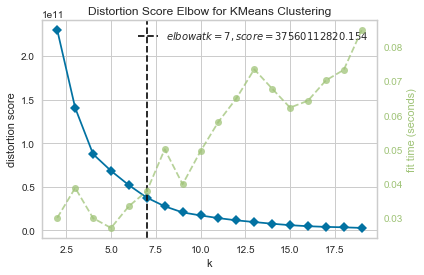

Optimal k-value:  7



Cluster the feature data into 7 clusters. Append the cluster labels to the dataframe.


,Borough,Neighborhood,ZIP Codes,Latitude,Longitude,Cluster Labels,Population,% Chinese,Mean Density (persons / sq. mi),Avg Rating,Avg Like Count,Variance Rating,Variance Like Count
0,Bronx,High Bridge and Morrisania,"[10451, 10452, 10456]",40.829625,-73.919533,2,40961.0,0.470000,47063.600000,5.200000,1.5,0.000000,1.85
1,Brooklyn,Central Brooklyn,"[11212, 11213, 11216, 11233, 11238]",40.674294,-73.935457,2,48965.0,0.830000,46994.100000,6.400000,3.9,0.715000,37.69
2,Brooklyn,Southwest Brooklyn,"[11209, 11214, 11228]",40.615247,-74.015602,0,194558.0,11.714607,35087.866667,8.133333,34.8,0.015556,6226.16
3,Brooklyn,Borough Park,"[11204, 11218, 11219, 11230]",40.631545,-73.980169,6,324411.0,9.461178,54275.650000,6.500000,5.0,0.640000,52.60
4,Brooklyn,Southern Brooklyn,"[11223, 11224, 11229, 11235]",40.589240,-73.972705,6,286901.0,8.630097,32925.350000,6.600000,5.1,0.666667,46.69





Use Folium to map the clusters





Create a pivot table by using the cluster labels as a pivot. All the rows with the same cluster labels are aggregated and the mean is displayed 


,% Chinese,Avg Like Count,Avg Rating,Latitude,Longitude,Mean Density (persons / sq. mi),Population,Variance Like Count,Variance Rating
Cluster Labels,,,,,,,,,
0,3.417635,21.322222,6.827160,40.705485,-73.942972,56920.855741,212057.666667,3956.881111,0.472258
1,22.905215,308.700000,7.530000,40.725438,-73.985665,96695.033333,197138.000000,154485.410000,0.870100
2,4.923939,21.900000,6.760933,40.720260,-73.915533,37023.202778,93060.916667,3789.960000,0.630851
3,8.145222,8.100000,7.300000,40.748477,-73.882663,43226.728571,477516.000000,107.690000,0.155000
4,2.956420,284.800000,7.300000,40.748909,-73.975940,72918.725000,124468.000000,273779.160000,0.996000
5,17.789637,206.000000,7.647857,40.717756,-74.006792,56589.125000,56487.500000,127673.160000,0.185205
6,7.555579,3.020000,6.603333,40.705947,-73.905616,45427.251333,281496.600000,25.302000,0.544944


In [161]:
clusterAnalysis(features)

### Clustering Based on Population, % Chinese, Avg Rating, and Avg Likes

In [162]:
secondFeatures=features.drop(features.columns[[0,3,6,7]], axis=1)
secondFeatures.head()

,Population,% Chinese,Avg Rating,Avg Like Count
0,40961.0,0.470000,5.200000,1.5
1,48965.0,0.830000,6.400000,3.9
2,194558.0,11.714607,8.133333,34.8
3,324411.0,9.461178,6.500000,5.0
4,286901.0,8.630097,6.600000,5.1


Find the optimum k-value using YellowBrick's kelbow_visualizer.


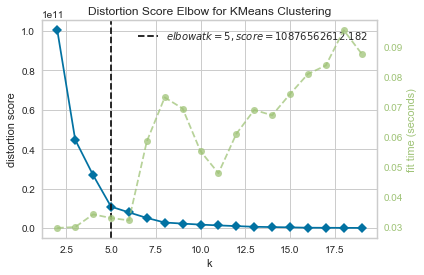

Optimal k-value:  5



Cluster the feature data into 5 clusters. Append the cluster labels to the dataframe.


,Borough,Neighborhood,ZIP Codes,Latitude,Longitude,Cluster Labels,Population,% Chinese,Avg Rating,Avg Like Count
0,Bronx,High Bridge and Morrisania,"[10451, 10452, 10456]",40.829625,-73.919533,0,40961.0,0.470000,5.200000,1.5
1,Brooklyn,Central Brooklyn,"[11212, 11213, 11216, 11233, 11238]",40.674294,-73.935457,0,48965.0,0.830000,6.400000,3.9
2,Brooklyn,Southwest Brooklyn,"[11209, 11214, 11228]",40.615247,-74.015602,1,194558.0,11.714607,8.133333,34.8
3,Brooklyn,Borough Park,"[11204, 11218, 11219, 11230]",40.631545,-73.980169,4,324411.0,9.461178,6.500000,5.0
4,Brooklyn,Southern Brooklyn,"[11223, 11224, 11229, 11235]",40.589240,-73.972705,4,286901.0,8.630097,6.600000,5.1





Use Folium to map the clusters





Create a pivot table by using the cluster labels as a pivot. All the rows with the same cluster labels are aggregated and the mean is displayed 


,% Chinese,Avg Like Count,Avg Rating,Latitude,Longitude,Population
Cluster Labels,,,,,,
0,4.199920,46.86,6.607143,40.686505,-73.963040,42483.0
1,5.366393,50.06,6.897444,40.707480,-73.947242,210565.7
2,8.145222,8.10,7.300000,40.748477,-73.882663,477516.0
3,7.662336,72.53,7.069119,40.739501,-73.916072,114175.9
4,7.555579,3.02,6.603333,40.705947,-73.905616,281496.6


In [163]:
clusterAnalysis(secondFeatures)

### Clustering Based on Population, % Chinese, and Avg Rating

In [164]:
thirdFeatures=secondFeatures.drop(secondFeatures.columns[[0,4]], axis=1)
thirdFeatures.head()

,Population,% Chinese,Avg Rating
0,40961.0,0.470000,5.200000
1,48965.0,0.830000,6.400000
2,194558.0,11.714607,8.133333
3,324411.0,9.461178,6.500000
4,286901.0,8.630097,6.600000


Find the optimum k-value using YellowBrick's kelbow_visualizer.


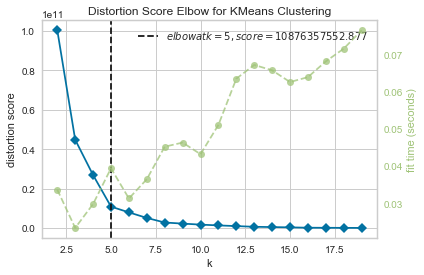

Optimal k-value:  5



Cluster the feature data into 5 clusters. Append the cluster labels to the dataframe.


,Borough,Neighborhood,ZIP Codes,Latitude,Longitude,Cluster Labels,Population,% Chinese,Avg Rating
0,Bronx,High Bridge and Morrisania,"[10451, 10452, 10456]",40.829625,-73.919533,4,40961.0,0.470000,5.200000
1,Brooklyn,Central Brooklyn,"[11212, 11213, 11216, 11233, 11238]",40.674294,-73.935457,4,48965.0,0.830000,6.400000
2,Brooklyn,Southwest Brooklyn,"[11209, 11214, 11228]",40.615247,-74.015602,0,194558.0,11.714607,8.133333
3,Brooklyn,Borough Park,"[11204, 11218, 11219, 11230]",40.631545,-73.980169,3,324411.0,9.461178,6.500000
4,Brooklyn,Southern Brooklyn,"[11223, 11224, 11229, 11235]",40.589240,-73.972705,3,286901.0,8.630097,6.600000





Use Folium to map the clusters





Create a pivot table by using the cluster labels as a pivot. All the rows with the same cluster labels are aggregated and the mean is displayed 


,% Chinese,Avg Rating,Latitude,Longitude,Population
Cluster Labels,,,,,
0,5.366393,6.897444,40.707480,-73.947242,210565.7
1,7.662336,7.069119,40.739501,-73.916072,114175.9
2,8.145222,7.300000,40.748477,-73.882663,477516.0
3,7.555579,6.603333,40.705947,-73.905616,281496.6
4,4.199920,6.607143,40.686505,-73.963040,42483.0


In [165]:
clusterAnalysis(thirdFeatures)

### Clustering Based on Population and Avg Rating

In [166]:
fourthFeatures=thirdFeatures.drop(thirdFeatures.columns[[0,2]], axis=1)
fourthFeatures.head()

,Population,Avg Rating
0,40961.0,5.200000
1,48965.0,6.400000
2,194558.0,8.133333
3,324411.0,6.500000
4,286901.0,6.600000


Find the optimum k-value using YellowBrick's kelbow_visualizer.


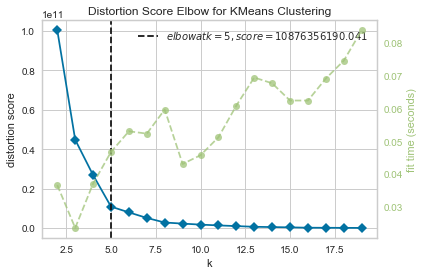

Optimal k-value:  5



Cluster the feature data into 5 clusters. Append the cluster labels to the dataframe.


,Borough,Neighborhood,ZIP Codes,Latitude,Longitude,Cluster Labels,Population,Avg Rating
0,Bronx,High Bridge and Morrisania,"[10451, 10452, 10456]",40.829625,-73.919533,4,40961.0,5.200000
1,Brooklyn,Central Brooklyn,"[11212, 11213, 11216, 11233, 11238]",40.674294,-73.935457,4,48965.0,6.400000
2,Brooklyn,Southwest Brooklyn,"[11209, 11214, 11228]",40.615247,-74.015602,3,194558.0,8.133333
3,Brooklyn,Borough Park,"[11204, 11218, 11219, 11230]",40.631545,-73.980169,0,324411.0,6.500000
4,Brooklyn,Southern Brooklyn,"[11223, 11224, 11229, 11235]",40.589240,-73.972705,0,286901.0,6.600000





Use Folium to map the clusters





Create a pivot table by using the cluster labels as a pivot. All the rows with the same cluster labels are aggregated and the mean is displayed 


,Avg Rating,Latitude,Longitude,Population
Cluster Labels,,,,
0,6.603333,40.705947,-73.905616,281496.6
1,7.069119,40.739501,-73.916072,114175.9
2,7.300000,40.748477,-73.882663,477516.0
3,6.897444,40.707480,-73.947242,210565.7
4,6.607143,40.686505,-73.963040,42483.0


In [167]:
clusterAnalysis(fourthFeatures)

<!--Created by Teresa Wang-->

Created by Teresa Wang